In [1]:
import sys
sys.path.append('..')
import h5py
import jax
import yaml
import matplotlib
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use('../flowrec/utils/a4.mplstyle')

import flowrec.data as data_utils
import flowrec.physics_and_derivatives as derivatives
import flowrec.training_and_states as state_utils

from ml_collections import config_dict
from pathlib import Path
from scipy.interpolate import RBFInterpolator
from mpl_toolkits.axes_grid1 import ImageGrid
from flowrec import losses
from flowrec.utils import simulation, my_discrete_cmap
from flowrec.utils.py_helper import slice_from_tuple
from flowrec.utils.system import set_gpu
set_gpu(1,0.5)

In [2]:
result_dir = Path('../local_results/2dtriangle/repeat_noisy/noisy_random')
if not result_dir.exists():
    raise ValueError

In [31]:
def get_summary_one_case(folder):
    with h5py.File(Path(result_dir,folder,'summary.h5')) as hf:
        l_train = np.array(hf.get('runs_loss_train'))
        l_val = np.array(hf.get('runs_loss_val'))
        idx = np.argmin(np.sum(l_train[:,1:],axis=-1))
        best_run = np.array(hf.get('runs_name')).astype('unicode')[idx]
    # best_run_path = Path(result_dir,folder,best_run)
    
    lmean = np.array([np.mean(l_train[:,0]), np.mean(l_val[:,0])]) # mean over the repeats [rel_l2 train, rel_l2 val]
    lstd = np.array([np.std(l_train[:,0]), np.std(l_val[:,0])]) # std over the repeats [rel_l2 train, rel_l2 val]
    lpmean = np.array([
        np.mean(np.sum(l_train[:,1:3],axis=1)),
        np.mean(np.sum(l_val[:,1:3],axis=1))
    ])
    lpstd = np.array([
        np.std(np.sum(l_train[:,1:3],axis=1)),
        np.std(np.sum(l_val[:,1:3],axis=1))
    ])
    print(best_run)
 
    return lmean, lstd, lpmean, lpstd

## Load summary file

In [32]:
lmean_snr20_classic, lstd_snr20_classic, lpmean_snr20_classic, lpstd_snr20_classic = get_summary_one_case('snr20_classic')
lmean_snr20_3, lstd_snr20_3, lpmean_snr20_3, lpstd_snr20_3 = get_summary_one_case('snr20_3')
lmean_snr20_mean3, lstd_snr20_mean3, lpmean_snr20_mean3, lpstd_snr20_mean3 = get_summary_one_case('snr20_mean3')

lmean_snr10_classic, lstd_snr10_classic, lpmean_snr10_classic, lpstd_snr10_classic = get_summary_one_case('snr10_classic')
lmean_snr10_3, lstd_snr10_3, lpmean_snr10_3, lpstd_snr10_3 = get_summary_one_case('snr10_3')
lmean_snr10_mean3, lstd_snr10_mean3, lpmean_snr10_mean3, lpstd_snr10_mean3, = get_summary_one_case('snr10_mean3')

lmean_snr5_classic, lstd_snr5_classic, lpmean_snr5_classic, lpstd_snr5_classic = get_summary_one_case('snr5_classic')
lmean_snr5_3, lstd_snr5_3, lpmean_snr5_3, lpstd_snr5_3 = get_summary_one_case('snr5_3')
lmean_snr5_mean3, lstd_snr5_mean3, lpmean_snr5_mean3, lpstd_snr5_mean3 = get_summary_one_case('snr5_mean3')


classic-325
3-86481
mean3-39
classic-278
3-325
mean3-325
classic-325
3-16
mean3-39


In [79]:
best_run_seed = str(325)

run_snr20_classic = Path(result_dir,'snr20_classic/classic-'+best_run_seed)
run_snr10_classic = Path(result_dir,'snr10_classic/classic-'+best_run_seed)
run_snr5_classic = Path(result_dir,'snr5_classic/classic-'+best_run_seed)
run_snr20_3 = Path(result_dir,'snr20_3/3-'+best_run_seed)
run_snr10_3 = Path(result_dir,'snr10_3/3-'+best_run_seed)
run_snr5_3 = Path(result_dir,'snr5_3/3-'+best_run_seed)
run_snr20_mean3 = Path(result_dir,'snr20_mean3/mean3-'+best_run_seed)
run_snr10_mean3 = Path(result_dir,'snr10_mean3/mean3-'+best_run_seed)
run_snr5_mean3 = Path(result_dir,'snr5_mean3/mean3-'+best_run_seed)

Compare relative error

In [50]:
l_mean_classic = []
l_mean_classic.append(lmean_snr20_classic)
l_mean_classic.append(lmean_snr10_classic)
l_mean_classic.append(lmean_snr5_classic)
l_mean_classic = np.array(l_mean_classic)*100
l_std_classic = []
l_std_classic.append(lstd_snr20_classic)
l_std_classic.append(lstd_snr10_classic)
l_std_classic.append(lstd_snr5_classic)
l_std_classic = np.array(l_std_classic)*100

l_mean_3 = []
l_mean_3.append(lmean_snr20_3)
l_mean_3.append(lmean_snr10_3)
l_mean_3.append(lmean_snr5_3)
l_mean_3 = np.array(l_mean_3)*100
l_std_3 = []
l_std_3.append(lstd_snr20_3)
l_std_3.append(lstd_snr10_3)
l_std_3.append(lstd_snr5_3)
l_std_3 = np.array(l_std_3)*100

l_mean_mean3 = []
l_mean_mean3.append(lmean_snr20_mean3)
l_mean_mean3.append(lmean_snr10_mean3)
l_mean_mean3.append(lmean_snr5_mean3)
l_mean_mean3 = np.array(l_mean_mean3)*100
l_std_mean3 = []
l_std_mean3.append(lstd_snr20_mean3)
l_std_mean3.append(lstd_snr10_mean3)
l_std_mean3.append(lstd_snr5_mean3)
l_std_mean3 = np.array(l_std_mean3)*100

In [51]:
# l_mean_classic - rows: 20,10,5 snr. columns: training,testing

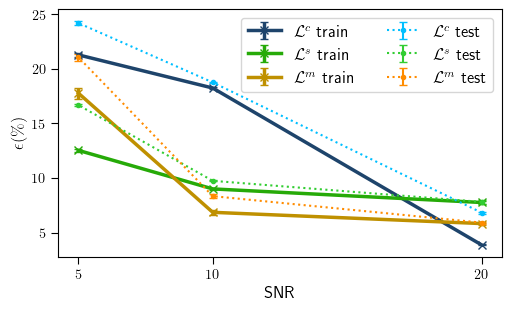

Mean and standard deviatin of the rel-L2 for loss classic, strict and mean at
SNR20: 3.87+-0.0464, 7.752+-0.1559, 5.822+-0.0917
SNR10: 18.23+-0.1072, 8.995+-0.0810, 6.852+-0.2470
SNR5: 21.27+-0.2082, 12.526+-0.1260, 17.768+-0.5095


In [64]:
snr = [20,10,5]
plt.figure(figsize=(5,3))
ax = plt.subplot(111)

ax.errorbar(snr,l_mean_classic[:,0],yerr=l_std_classic[:,0],label='$\mathcal{L}^c$ train',marker='x',color=my_discrete_cmap(0),linewidth=2.5)
ax.errorbar(snr,l_mean_3[:,0],yerr=l_std_3[:,0],label='$\mathcal{L}^s$ train',marker='x',color=my_discrete_cmap(1),linewidth=2.5)
ax.errorbar(snr,l_mean_mean3[:,0],yerr=l_std_mean3[:,0],label='$\mathcal{L}^m$ train',marker='x',color=my_discrete_cmap(2),linewidth=2.5)

ax.errorbar(snr,l_mean_classic[:,1],yerr=l_std_classic[:,1],label='$\mathcal{L}^c$ test',marker='.',color='deepskyblue',linestyle=':')
ax.errorbar(snr,l_mean_3[:,1],yerr=l_std_3[:,1],label='$\mathcal{L}^s$ test',marker='.',linestyle=':',color='limegreen')
ax.errorbar(snr,l_mean_mean3[:,1],yerr=l_std_mean3[:,1],label='$\mathcal{L}^m$ test',marker='.',linestyle=':',color='darkorange',)

ax.legend(ncol=2,loc='upper right')
ax.set_ylabel('$\epsilon (\%)$')
ax.set_xticks([5,10,20])
ax.set_xlabel('SNR')
# ax.set_yscale('log')
# plt.ylim([0,70])
plt.show()


print('Mean and standard deviatin of the rel-L2 for loss classic, strict and mean at')
print(f'SNR20: {l_mean_classic[0,0]:.2f}+-{l_std_classic[0,0]:.4f}, {l_mean_3[0,0]:.3f}+-{l_std_3[0,0]:.4f}, {l_mean_mean3[0,0]:.3f}+-{l_std_mean3[0,0]:.4f}')
print(f'SNR10: {l_mean_classic[1,0]:.2f}+-{l_std_classic[1,0]:.4f}, {l_mean_3[1,0]:.3f}+-{l_std_3[1,0]:.4f}, {l_mean_mean3[1,0]:.3f}+-{l_std_mean3[1,0]:.4f}')
print(f'SNR5: {l_mean_classic[2,0]:.2f}+-{l_std_classic[2,0]:.4f}, {l_mean_3[2,0]:.3f}+-{l_std_3[2,0]:.4f}, {l_mean_mean3[2,0]:.3f}+-{l_std_mean3[2,0]:.4f}')

Compare physics loss

In [65]:
lp_mean_classic = []
lp_mean_classic.append(lpmean_snr20_classic)
lp_mean_classic.append(lpmean_snr10_classic)
lp_mean_classic.append(lpmean_snr5_classic)
lp_mean_classic = np.array(lp_mean_classic)
lp_std_classic = []
lp_std_classic.append(lpstd_snr20_classic)
lp_std_classic.append(lpstd_snr10_classic)
lp_std_classic.append(lpstd_snr5_classic)
lp_std_classic = np.array(lp_std_classic)

lp_mean_3 = []
lp_mean_3.append(lpmean_snr20_3)
lp_mean_3.append(lpmean_snr10_3)
lp_mean_3.append(lpmean_snr5_3)
lp_mean_3 = np.array(lp_mean_3)
lp_std_3 = []
lp_std_3.append(lpstd_snr20_3)
lp_std_3.append(lpstd_snr10_3)
lp_std_3.append(lpstd_snr5_3)
lp_std_3 = np.array(lp_std_3)

lp_mean_mean3 = []
lp_mean_mean3.append(lpmean_snr20_mean3)
lp_mean_mean3.append(lpmean_snr10_mean3)
lp_mean_mean3.append(lpmean_snr5_mean3)
lp_mean_mean3 = np.array(lp_mean_mean3)
lp_std_mean3 = []
lp_std_mean3.append(lpstd_snr20_mean3)
lp_std_mean3.append(lpstd_snr10_mean3)
lp_std_mean3.append(lpstd_snr5_mean3)
lp_std_mean3 = np.array(lp_std_mean3)

lp_ref = 0.043 # this is the data

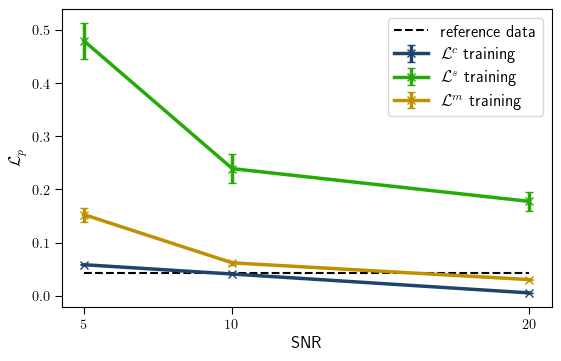

Mean and standard deviatin of the physics loss for loss classic, strict and mean at
SNR20: 0.01+-0.0003, 0.177+-0.0183, 0.030+-0.0008
SNR10: 0.04+-0.0006, 0.239+-0.0275, 0.062+-0.0043
SNR5: 0.06+-0.0009, 0.480+-0.0337, 0.153+-0.0131
Physics loss of the reference data is 0.0430


In [66]:
snr = [20,10,5]
plt.figure(figsize=(5.5,3.5))
ax = plt.subplot(111)

# training set
ax.errorbar(snr,lp_mean_classic[:,0],yerr=lp_std_classic[:,0],label='$\mathcal{L}^c$ training',marker='x',color=my_discrete_cmap(0),linewidth=2.5)
ax.errorbar(snr,lp_mean_3[:,0],yerr=lp_std_3[:,0],label='$\mathcal{L}^s$ training',marker='x',color=my_discrete_cmap(1),linewidth=2.5)
ax.errorbar(snr,lp_mean_mean3[:,0],yerr=lp_std_mean3[:,0],label='$\mathcal{L}^m$ training',marker='x',color=my_discrete_cmap(2),linewidth=2.5)

# # validation set
# ax.errorbar(snr,lp_mean_classic[:,1],yerr=lp_std_classic[:,1],label='$\mathcal{L}^c$ testing',marker='.',color='deepskyblue',linestyle=':')
# ax.errorbar(snr,lp_mean_3[:,1],yerr=lp_std_3[:,1],label='$\mathcal{L}^s$ testing',marker='.',linestyle=':',color='darkorange')
# ax.errorbar(snr,lp_mean_mean3[:,1],yerr=lp_std_mean3[:,1],label='$\mathcal{L}^m$ testing',marker='.',linestyle=':',color='limegreen',)

ax.hlines(lp_ref, xmin=5,xmax=20, colors=['k'], linestyles='dashed',label='reference data')
ax.legend(ncol=1)
ax.set_ylabel('$\mathcal{L}_p$')
ax.set_xticks([5,10,20])
ax.set_xlabel('SNR')
# ax.set_yscale('log')
# plt.ylim([0,70])
plt.show()


print('Mean and standard deviatin of the physics loss for loss classic, strict and mean at')
print(f'SNR20: {lp_mean_classic[0,0]:.2f}+-{lp_std_classic[0,0]:.4f}, {lp_mean_3[0,0]:.3f}+-{lp_std_3[0,0]:.4f}, {lp_mean_mean3[0,0]:.3f}+-{lp_std_mean3[0,0]:.4f}')
print(f'SNR10: {lp_mean_classic[1,0]:.2f}+-{lp_std_classic[1,0]:.4f}, {lp_mean_3[1,0]:.3f}+-{lp_std_3[1,0]:.4f}, {lp_mean_mean3[1,0]:.3f}+-{lp_std_mean3[1,0]:.4f}')
print(f'SNR5: {lp_mean_classic[2,0]:.2f}+-{lp_std_classic[2,0]:.4f}, {lp_mean_3[2,0]:.3f}+-{lp_std_3[2,0]:.4f}, {lp_mean_mean3[2,0]:.3f}+-{lp_std_mean3[2,0]:.4f}')
print(f'Physics loss of the reference data is {lp_ref:.4f}')

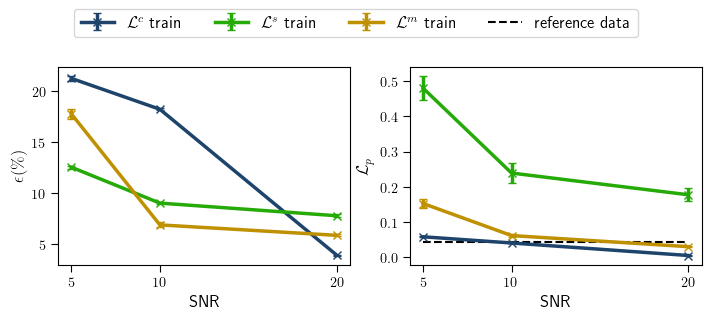

In [67]:
fig, (axl, axr) = plt.subplots(1,2,figsize=(7,2.5), sharex=True)

axl.errorbar(snr,l_mean_classic[:,0],yerr=l_std_classic[:,0],label='$\mathcal{L}^c$ train',marker='x',color=my_discrete_cmap(0),linewidth=2.5)
axl.errorbar(snr,l_mean_3[:,0],yerr=l_std_3[:,0],label='$\mathcal{L}^s$ train',marker='x',color=my_discrete_cmap(1),linewidth=2.5)
axl.errorbar(snr,l_mean_mean3[:,0],yerr=l_std_mean3[:,0],label='$\mathcal{L}^m$ train',marker='x',color=my_discrete_cmap(2),linewidth=2.5)

# axl.errorbar(snr,l_mean_classic[:,1],yerr=l_std_classic[:,1],label='$\mathcal{L}^c$ test',marker='.',color='deepskyblue',linestyle=':')
# axl.errorbar(snr,l_mean_3[:,1],yerr=l_std_3[:,1],label='$\mathcal{L}^s$ test',marker='.',linestyle=':',color='limegreen')
# axl.errorbar(snr,l_mean_mean3[:,1],yerr=l_std_mean3[:,1],label='$\mathcal{L}^m$ test',marker='.',linestyle=':',color='darkorange',)

axl.set_ylabel('$\epsilon (\%)$')
axl.set_xticks([5,10,20])
axl.set_xlabel('SNR')

axr.errorbar(snr,lp_mean_classic[:,0],yerr=lp_std_classic[:,0],marker='x',color=my_discrete_cmap(0),linewidth=2.5)
axr.errorbar(snr,lp_mean_3[:,0],yerr=lp_std_3[:,0], marker='x',color=my_discrete_cmap(1),linewidth=2.5)
axr.errorbar(snr,lp_mean_mean3[:,0],yerr=lp_std_mean3[:,0],marker='x',color=my_discrete_cmap(2),linewidth=2.5)
axr.hlines(lp_ref, xmin=5,xmax=20, colors=['k'], linestyles='dashed',label='reference data')
# axr.legend(ncol=1)
axr.set_ylabel('$\mathcal{L}_p$')
axr.set_xticks([5,10,20])
axr.set_xlabel('SNR')

fig.legend(ncol=4,loc='upper center', bbox_to_anchor=(0.5, 1.25))
# fig.savefig('./figs/2dtriangle_noisy_compare_lossfn',bbox_inches='tight')
plt.show()

## Compare flowfields

### Functions to get results

In [68]:
def interpolate(u,pb,case_observe,datacfg):

    take_observation, insert_observation = case_observe(datacfg, example_pred_snapshot=u[0,...],example_pin_snapshot=pb[0,...])
    observed = take_observation(u)
    temp_observed = np.empty_like(u)
    temp_observed.fill(np.nan) #this is noisy
    temp_observed = insert_observation(jnp.asarray(temp_observed),jnp.asarray(observed)) # observed_test is noisy if

    # get sensor coordinates
    sensors_empty = np.empty_like(u[[0],...])
    sensors_empty.fill(np.nan)

    grid_x,grid_y = np.mgrid[0:u[...,0].shape[1], 0:u[...,0].shape[2]]

    gridx1 = np.repeat(grid_x[None,:,:,None],3,axis=3)
    gridy1 = np.repeat(grid_y[None,:,:,None],3,axis=3)

    idx_x = take_observation(gridx1)
    idx_y = take_observation(gridy1)

    idx_x = insert_observation(jnp.asarray(sensors_empty),jnp.asarray(idx_x))[0,...]
    sensors_loc_x = []
    for i in range(idx_x.shape[-1]):
        sensors_loc_x.append(idx_x[...,i][~np.isnan(idx_x[...,i])])

    idx_y = insert_observation(jnp.asarray(sensors_empty),jnp.asarray(idx_y))[0,...]
    sensors_loc_y = []
    for i in range(idx_y.shape[-1]):
        sensors_loc_y.append(idx_y[...,i][~np.isnan(idx_y[...,i])])


    compare_interp = list([])
    nt = u.shape[0]
    _locs = np.stack((grid_x.flatten(),grid_y.flatten()),axis=-1)

    print('Starting interpolation')
    for i in range(3):
        print(f"Component {i}")
        sensors_loc = np.stack((sensors_loc_x[i].flatten(),sensors_loc_y[i].flatten()),axis=-1)
        for j in range(nt):
            if j%50 == 0:
                print(j)
            temp_measurement = temp_observed[j,...,i][~np.isnan(temp_observed[j,...,i])]
            # print(sensors_loc.shape, temp_measurement.shape)
            rbf = RBFInterpolator(sensors_loc,temp_measurement.flatten(),kernel='thin_plate_spline')
            _interp = rbf(_locs).reshape(grid_x.shape)
            compare_interp.append(_interp)
    compare_interp = np.array(compare_interp)
    compare_interp = np.stack((compare_interp[:nt,...],compare_interp[nt:2*nt,...],compare_interp[2*nt:3*nt,...]),axis=-1)

    return compare_interp, temp_observed

In [69]:
def get_single_case_predictions(results_dir, predict_only=False):
    print(f"Starting {results_dir}")
    with open(Path(results_dir,'config.yml'),'r') as f:
        cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
    cfg.data_config.update({'data_dir':'.'+cfg.data_config.data_dir})
    x_base = 132
    triangle_base_coords = [49,80]
    (ux,uy,pp) = simulation.read_data_2dtriangle(cfg.data_config.data_dir,x_base)
    x = np.stack([ux,uy,pp],axis=0)
    # remove parts where uz is not zero
    s = slice_from_tuple(cfg.data_config.slice_to_keep)
    x = x[s]

    # information about the grid
    datainfo = data_utils.DataMetadata(
        re = cfg.data_config.re,
        discretisation=[cfg.data_config.dt,cfg.data_config.dx,cfg.data_config.dy],
        axis_index=[0,1,2],
        problem_2d=True
    ).to_named_tuple()

    rng = np.random.default_rng(cfg.data_config.randseed)
    if cfg.data_config.snr:
        [x_train,x_val,x_test], _ = data_utils.data_partition(x,1,cfg.data_config.train_test_split,REMOVE_MEAN=cfg.data_config.remove_mean,randseed=cfg.data_config.randseed,SHUFFLE=cfg.data_config.shuffle) # Do not shuffle, do not remove mean for training with physics informed loss
        [ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
        # [ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
        # [ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))
        u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
        # u_val = np.stack((ux_val,uy_val,pp_val),axis=-1)
        # u_test = np.stack((ux_test,uy_test,pp_test),axis=-1)

        
        std_data = np.std(x,axis=(1,2,3),ddof=1)
        std_n = data_utils.get_whitenoise_std(cfg.data_config.snr,std_data)
        noise_ux = rng.normal(scale=std_n[0],size=x[0,...].shape)
        noise_uy = rng.normal(scale=std_n[1],size=x[1,...].shape)
        noise_pp = rng.normal(scale=std_n[2],size=x[2,...].shape)
        noise = np.stack([noise_ux,noise_uy,noise_pp],axis=0)
        x = x + noise


    [x_train_n,x_val_n,x_test_n], _ = data_utils.data_partition(
        x,
        1,
        cfg.data_config.train_test_split,
        REMOVE_MEAN=cfg.data_config.remove_mean,
        randseed=cfg.data_config.randseed,
        SHUFFLE=cfg.data_config.shuffle
    ) # Do not shuffle, do not remove mean for training with physics informed loss
    [ux_train_n,uy_train_n,pp_train_n] = np.squeeze(np.split(x_train_n,3,axis=0))
    [ux_val_n,uy_val_n,pp_val_n] = np.squeeze(np.split(x_val_n,3,axis=0))
    [ux_test_n,uy_test_n,pp_test_n] = np.squeeze(np.split(x_test_n,3,axis=0))
    u_train_n = np.stack((ux_train_n,uy_train_n,pp_train_n),axis=-1)
    u_val_n = np.stack((ux_val_n,uy_val_n,pp_val_n),axis=-1)
    u_test_n = np.stack((ux_test_n,uy_test_n,pp_test_n),axis=-1)

    pb_train = simulation.take_measurement_base(pp_train_n,ly=triangle_base_coords,centrex=0).reshape((cfg.data_config.train_test_split[0],-1))
    pb_val = simulation.take_measurement_base(pp_val_n,ly=triangle_base_coords,centrex=0).reshape((cfg.data_config.train_test_split[1],-1))
    pb_test = simulation.take_measurement_base(pp_test_n,ly=triangle_base_coords,centrex=0).reshape((cfg.data_config.train_test_split[2],-1))

    take_observation, insert_observation = cfg.case.observe(cfg.data_config, example_pred_snapshot=u_train_n[0,...],example_pin_snapshot=pb_train[0,...])
    observed_train, train_minmax = take_observation(u_train_n,init=True)
    observed_val, val_minmax = take_observation(u_val_n,init=True)
    observed_test, test_minmax = take_observation(u_test_n,init=True)
    
    state = state_utils.restore_trainingstate(results_dir,'state')
    _, make_model = cfg.case.select_model(datacfg=cfg.data_config, mdlcfg=cfg.model_config, traincfg=cfg.train_config)
    mdl = make_model(cfg.model_config)

    if cfg.data_config.normalise:
        [pb_train, pb_val, pb_test], _ = data_utils.normalise(pb_train, pb_val, pb_test, range=[train_minmax[-1],val_minmax[-1],test_minmax[-1]])

    rng = jax.random.PRNGKey(10)

    pb_train_batch = np.array_split(pb_train,2,0)
    pred_train = []
    for inn in pb_train_batch:
        pred_train.append(mdl.apply(state.params,rng,inn,TRAINING=False))
    pred_train = np.concatenate(pred_train)
    # pred_test = mdl.apply(state.params,rng,pb_test,TRAINING=False)
    if cfg.data_config.normalise:
        pred_train = data_utils.unnormalise_group(pred_train, train_minmax, axis_data=-1, axis_range=0)
        # pred_test = data_utils.unnormalise_group(pred_test, test_minmax, axis_data=-1, axis_range=0)
    
    if predict_only:
        return pred_train 

    u_interp, observed = interpolate(u_train_n, pb_train, cfg.case.observe, cfg.data_config)
    
    print(f'Finished {results_dir}')

    return (u_train ,u_train_n, u_interp, pred_train), datainfo, observed

### Functions to plot

In [70]:
def make_image_snapshots(data, figname, t1):
    # data is (ref, noisy, interp, classic, loss3, mean3)

    ref = data[0]

    fig = plt.figure(figsize=(7,4))
    
    # grids for mean
    grid_b1 = ImageGrid(fig, (0.08,0.00,0.92,0.14), (1,6),cbar_mode='single', share_all=True)
    grid_b2 = ImageGrid(fig, (0.08,0.15,0.92,0.14), (1,6),cbar_mode='single', share_all=True)
    grid_b3 = ImageGrid(fig, (0.08,0.30,0.92,0.14), (1,6),cbar_mode='single', share_all=True)
    
    # grids for snapshots
    grid_t1 = ImageGrid(fig, (0.08,0.50,0.92,0.14), (1,6),cbar_mode='single', share_all=True)
    grid_t2 = ImageGrid(fig, (0.08,0.65,0.92,0.14), (1,6),cbar_mode='single', share_all=True)
    grid_t3 = ImageGrid(fig, (0.08,0.80,0.92,0.14), (1,6),cbar_mode='single', share_all=True)
    
    # snapshots
    for i, grid in enumerate([grid_t3,grid_t2,grid_t1]):
        axes = grid.axes_all
        im_ref = axes[0].imshow(ref[t1,...,i].T)
        
        for j in range(1,6):
            im = axes[j].imshow(data[j][t1,...,i].T)
            im.set_clim(im_ref.get_clim()[0],im_ref.get_clim()[1])
        grid.cbar_axes[0].colorbar(im_ref)
        grid.axes_all[0].set(xticks=[],yticks=[])
    
    # mean
    for i, grid in enumerate([grid_b3,grid_b2,grid_b1]):
        axes = grid.axes_all
        im_ref = axes[0].imshow(np.mean(ref[...,i],axis=0).T)
        
        for j in range(1,6):
            im = axes[j].imshow(np.mean(data[j][...,i],axis=0).T)
            im.set_clim(im_ref.get_clim()[0],im_ref.get_clim()[1])
        grid.cbar_axes[0].colorbar(im_ref)
        grid.axes_all[0].set(xticks=[],yticks=[])
    
    
    fig.text(0.11,0.98,'Reference')
    fig.text(0.28,0.98,'Noisy')
    fig.text(0.41,0.98,'Interpolated')
    fig.text(0.60,0.98,'$\mathcal{L}^c$')
    fig.text(0.75,0.98,'$\mathcal{L}^s$')
    fig.text(0.9,0.98,'$\mathcal{L}^m$')
    fig.text(0.01,0.20,'Mean',rotation='vertical')
    fig.text(0.05,0.07, '$\overline{p}$')
    fig.text(0.05,0.22, '$\overline{u}_2$')
    fig.text(0.05,0.37, '$\overline{u}_1$')
    fig.text(0.01,0.70,f't={t1}',rotation='vertical')
    fig.text(0.05,0.57, '$p$')
    fig.text(0.05,0.72, '$u_2$')
    fig.text(0.05,0.87, '$u_1$')

    if figname:
        plt.savefig('./figs/'+figname,bbox_inches='tight')

In [71]:
var_names = ['$u_1^\prime$','$u_2^\prime$','$p^\prime$']

def make_image_freq(data, figname, dt):
    # data is (ref, noisy, interp, classic, loss3, mean3)

    n = np.prod(data[0].shape[1:-1])
    fftfreq = np.fft.fftfreq(data[0].shape[0],d = dt)
    midpoint = int(len(fftfreq)/2)
    
    # data
    f_data = np.einsum('t x y u -> t u', np.abs(np.fft.fft(data[0]-np.mean(data[0],axis=0),axis=0)))

    # interpolated
    interp_test_nonan = []
    for i in range(3):
        mask = ~np.isnan(data[2][0,...,i])
        interp_test_nonan.append(data[2][...,i][:,mask])
    f_interp = []
    for i in range(3):
        _interp = np.einsum('t n -> t', np.abs(np.fft.fft(interp_test_nonan[i]-np.mean(interp_test_nonan[i]),axis=0)))
        # _interp = _interp / np.std(_interp)
        f_interp.append(_interp)


    fig, axes = plt.subplots(1,3,sharex=True,figsize=(7,3))
    for i in range(3):
        axes[i].plot(fftfreq[:midpoint], 2*f_data[:midpoint,i],label='Reference',linewidth=3,color='#808080',alpha=0.5)
        axes[i].plot(fftfreq[:midpoint], 2*f_interp[i][:midpoint],label='Interpolated',linewidth=1,color='k',linestyle='--')
        
        for j,lossfn in enumerate(['$\mathcal{L}^c$','$\mathcal{L}^s$','$\mathcal{L}^m$']):
            f_pred = np.einsum('t x y u -> t u', np.abs(np.fft.fft(data[j+3]-np.mean(data[j+3],axis=0),axis=0)))
            axes[i].plot(fftfreq[:midpoint], 2*f_pred[:midpoint,i],label=lossfn,linewidth=1,color=my_discrete_cmap(j))
        axes[i].set(xlabel='Hz',title=var_names[i])
        
    axes[0].set(ylabel='Magnitude', xlim=[0,4])
        

    handlers = axes[0].get_legend_handles_labels()
    fig.legend(*handlers,loc='upper center', bbox_to_anchor=(0.5, 1.1),ncols=5)
    if figname:
        plt.savefig('./figs/'+figname,bbox_inches='tight')

In [72]:
def make_image_pdf(data,figname):

    ## interpolation
    interp_test_nonan = []
    for i in range(3):
        mask = ~np.isnan(data[2][0,...,i])
        interp_test_nonan.append(data[2][...,i][:,mask])

    ## plot
    fig,axes = plt.subplots(1,3,figsize=(7,3))
    for i,var in zip(range(3),['$u_1^\prime$','$u_2^\prime$','$p^\prime$']):
        # true
        counts_true,bins_true = np.histogram(data[0][...,i].flatten()-np.mean(data[0][...,i].flatten()), density=True, bins='auto')
        axes[i].stairs(counts_true,bins_true,label='True',linewidth=3, color='#808080',alpha=0.5)
        # interpolation
        counts,bins = np.histogram(interp_test_nonan[i].flatten()-np.mean(interp_test_nonan[i].flatten()), density=True, bins='auto')
        axes[i].stairs(counts,bins,label='Interp.',color='k',linestyle='--')
        
        # prediction
        for j,lossfn in enumerate(['$\mathcal{L}^c$','$\mathcal{L}^s$','$\mathcal{L}^m$']):
            counts,bins = np.histogram(data[j+3][...,i].flatten()-np.mean(data[j+3][...,i].flatten()), density=True, bins='auto')
            axes[i].stairs(counts,bins,label=lossfn)
        axes[i].set(xlabel=var)
    axes[0].set_ylabel('Probability density')

    handlers = axes[0].get_legend_handles_labels()
    fig.legend(*handlers,loc='upper center', bbox_to_anchor=(0.5, 1.1),ncols=5)

    if figname:
        plt.savefig('./figs/'+figname,bbox_inches='tight')
    else:
        plt.show()


### Results

In [73]:
plt_time = 100

SNR20

In [74]:
# takes about 10 minutes to run the cell
results_20, datainfo, observed_20 = get_single_case_predictions(run_snr20_classic)
results_20 = list(results_20)
for run in [run_snr20_3, run_snr20_mean3]:
    result = get_single_case_predictions(run, predict_only=True)
    results_20.append(result)
print('1')

Starting ../local_results/2dtriangle/repeat_noisy/noisy_random/snr20_classic/classic-325
Starting interpolation
Component 0
0
50
100
150
200
250
300
350
400
450
500
550
Component 1
0
50
100
150
200
250
300
350
400
450
500
550
Component 2
0
50
100
150
200
250
300
350
400
450
500
550
Finished ../local_results/2dtriangle/repeat_noisy/noisy_random/snr20_classic/classic-325
Starting ../local_results/2dtriangle/repeat_noisy/noisy_random/snr20_3/3-325
Starting ../local_results/2dtriangle/repeat_noisy/noisy_random/snr20_mean3/mean3-325
1


/tmp/ipykernel_1002200/457600368.py:57: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('./figs/'+figname,bbox_inches='tight')
/home/ym917/miniconda3/envs/fr/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


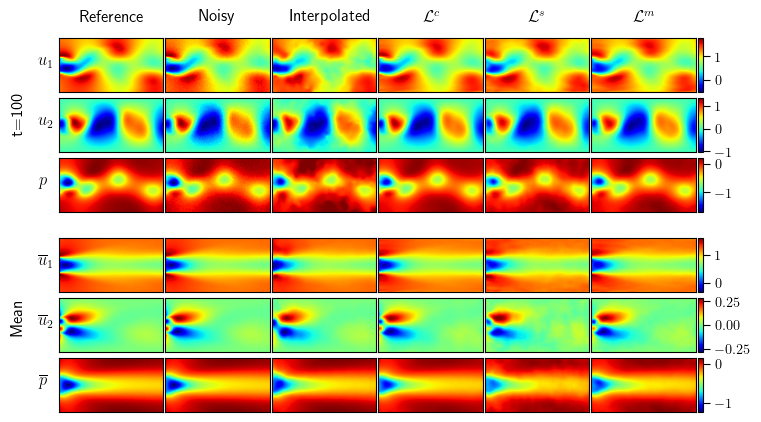

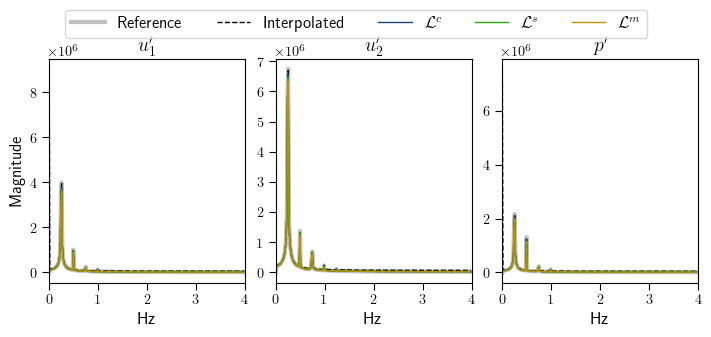

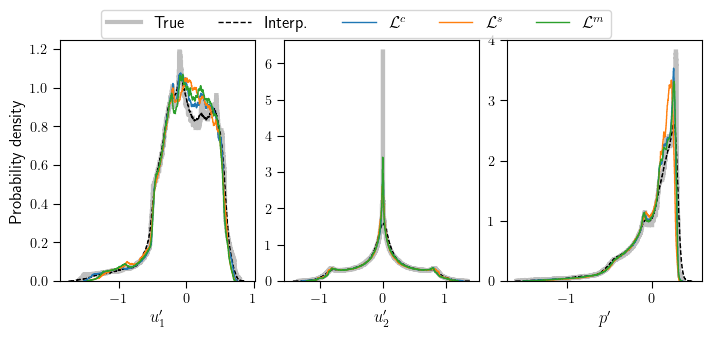

In [75]:
make_image_snapshots(results_20, '2dtriangle_noisy20_snapshots'+str(plt_time), plt_time)
make_image_freq(results_20, '2dtriangle_noisy20_freq', datainfo.dt)
make_image_pdf(results_20, '2dtriangle_noisy20_pdf')

SNR10

In [76]:
results_10, datainfo, observed_10 = get_single_case_predictions(run_snr10_classic)
results_10 = list(results_10)
for run in [run_snr10_3, run_snr10_mean3]:
    result = get_single_case_predictions(run, predict_only=True)
    results_10.append(result)
print('1')

Starting ../local_results/2dtriangle/repeat_noisy/noisy_random/snr10_classic/classic-325
Starting interpolation
Component 0
0
50
100
150
200
250
300
350
400
450
500
550
Component 1
0
50
100
150
200
250
300
350
400
450
500
550
Component 2
0
50
100
150
200
250
300
350
400
450
500
550
Finished ../local_results/2dtriangle/repeat_noisy/noisy_random/snr10_classic/classic-325
Starting ../local_results/2dtriangle/repeat_noisy/noisy_random/snr10_3/3-325
Starting ../local_results/2dtriangle/repeat_noisy/noisy_random/snr10_mean3/mean3-325
1


/tmp/ipykernel_1002200/457600368.py:57: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('./figs/'+figname,bbox_inches='tight')


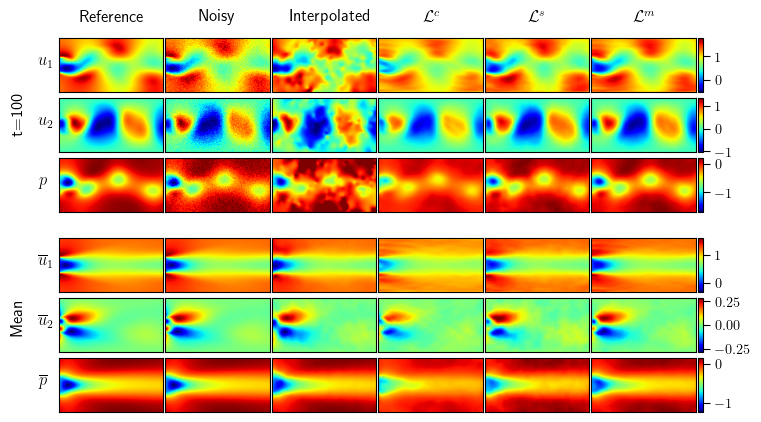

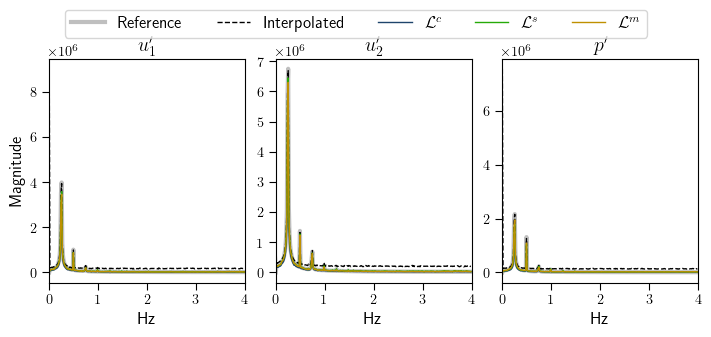

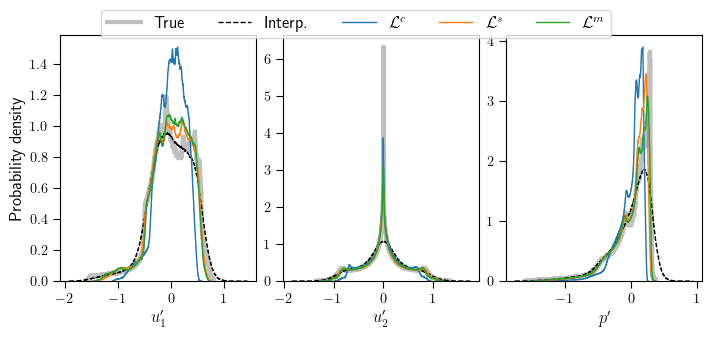

In [77]:
make_image_snapshots(results_10, '2dtriangle_noisy10_snapshots'+str(plt_time), plt_time)
make_image_freq(results_10, '2dtriangle_noisy10_freq', datainfo.dt)
make_image_pdf(results_10, '2dtriangle_noisy10_pdf')

SNR5

In [80]:
results_5, datainfo, observed_5 = get_single_case_predictions(run_snr5_classic)
results_5 = list(results_5)
for run in [run_snr5_3, run_snr5_mean3]:
    result = get_single_case_predictions(run, predict_only=True)
    results_5.append(result)
print('1')

Starting ../local_results/2dtriangle/repeat_noisy/noisy_random/snr5_classic/classic-325
Starting interpolation
Component 0
0
50
100
150
200
250
300
350
400
450
500
550
Component 1
0
50
100
150
200
250
300
350
400
450
500
550
Component 2
0
50
100
150
200
250
300
350
400
450
500
550
Finished ../local_results/2dtriangle/repeat_noisy/noisy_random/snr5_classic/classic-325
Starting ../local_results/2dtriangle/repeat_noisy/noisy_random/snr5_3/3-325
Starting ../local_results/2dtriangle/repeat_noisy/noisy_random/snr5_mean3/mean3-325
1


/tmp/ipykernel_1002200/457600368.py:57: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('./figs/'+figname,bbox_inches='tight')


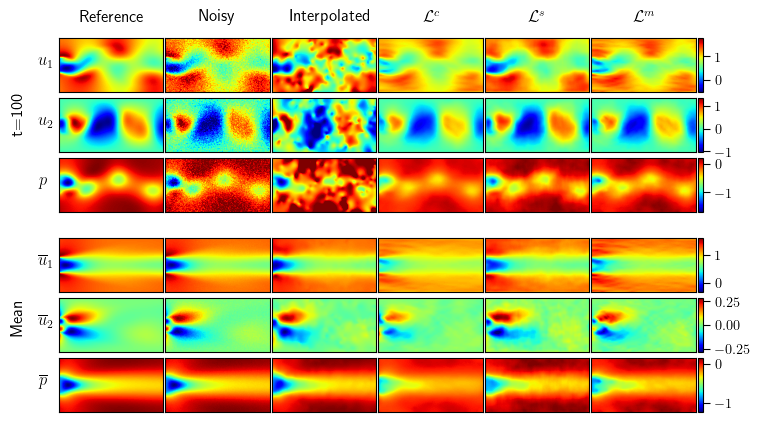

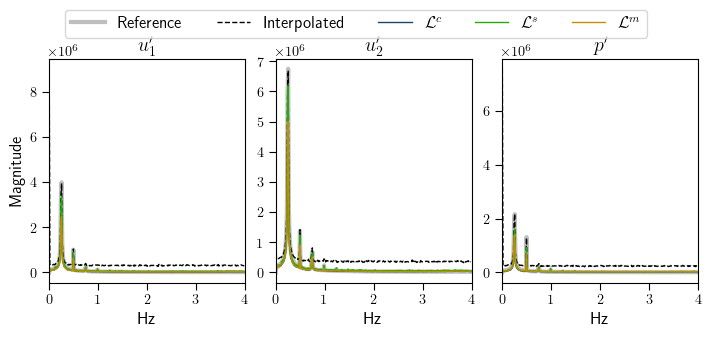

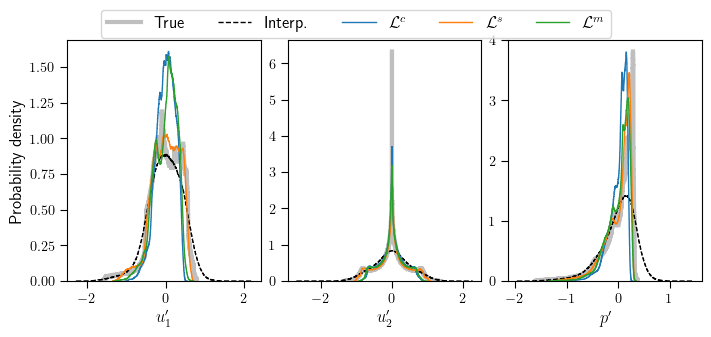

In [81]:
make_image_snapshots(results_5, '2dtriangle_noisy5_snapshots'+str(plt_time), plt_time)
make_image_freq(results_5, '2dtriangle_noisy5_freq', datainfo.dt)
make_image_pdf(results_5, '2dtriangle_noisy5_pdf')

### sensors

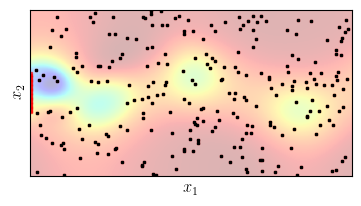

In [83]:
fig = plt.figure(figsize=(3.5,2))
plt.imshow(results_20[0][0,...,2].T, alpha=0.3)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.spy(observed_20[0,...,2].T, color='r', marker='s', markersize=2, alpha=0.6)
plt.spy(observed_20[0,...,1].T, color='k', marker='s', markersize=2)
plt.xticks([])
plt.yticks([])
# fig.savefig('./figs/2dtriangle_noisy_sensor_location')
plt.show()